<a href="https://colab.research.google.com/github/indrochoco/NYC-Taxi-prediction/blob/main/taxi_time_prediction_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## Importing libraries

For this project we are going to use these for EDA portion

1.   Numpy :- For its linear algebra functions and the advantage it offers over list in terms of speed and memory consumed
2.   Pandas :- This will be our primary data analysis library necessary for almost all of our data manipulations jobs
3.   Matplotlib :- Basic visualization library that we need for plotting and graphs
4.   Seaborn :- For more customizable and advanced data visualization


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle

Importing the csv file

<b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


In [47]:
path= '/content/drive/MyDrive/almabetter/Copy of NYC Taxi Data.csv'
taxi_data = pd.read_csv(path)

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.





### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

# EDA

### **Dataset Inspection**

In [48]:
# First 5 rows of the data 
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [49]:
taxi_data.shape #shape of the data set

(1458644, 11)

Inspecting the name of the features

In [50]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [51]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In the data set , there is no null value. 

Let's check if any duplicate column available

In [52]:
taxi_data[taxi_data.duplicated() == True]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [53]:
taxi_data.store_and_fwd_flag.unique() # checking the unique values of store_and_fwd_flag column

array(['N', 'Y'], dtype=object)

In [54]:
taxi_data.passenger_count.unique() # unique values of passengers carried by taxi

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

passenger number 0 is impossible. So, we will deal with it later, while we will do the outlier treatment. 

In [55]:
taxi_data.describe() # describing the data set

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


### Data processing 

Converting pickup and drop off column to date time format

In [56]:
taxi_data['dropoff_datetime']= pd.to_datetime(taxi_data['dropoff_datetime'])
taxi_data['pickup_datetime']= pd.to_datetime(taxi_data['pickup_datetime'])

Replace the 'yes' and 'no' by 1 & 0 respectively .

In [57]:
# Encoding the values
value= {'store_and_fwd_flag':{'N':0,'Y':1}}
taxi_data= taxi_data.replace(value) # Replacing categorical value with encoded number

In [58]:
# Checking if any longitude value is 0 
taxi_data[taxi_data.dropoff_longitude==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


### Calucating the distance between two points

In [59]:
import geopy.distance # Importing Geopy library for calculating the distance between two points. 

In [60]:
# First creating an empty list
dist_list= [] 
for k in range(taxi_data.shape[0]):

    # Point one
    lat1 = taxi_data.pickup_latitude[k]
    lon1 = taxi_data.pickup_longitude[k]

    # Point two
    lat2 = taxi_data.dropoff_latitude[k]
    lon2 = taxi_data.dropoff_longitude[k]

    # calculate distance between two points
    coords_1 = (lat1,lon1)
    coords_2 = (lat2,lon2)
    distance= geopy.distance.vincenty(coords_1, coords_2).km  # gives distance
    dist_list.append(distance)

# adding distance column to the dataset 
taxi_data['distance']= dist_list

In [61]:
taxi_data['distance'] # checking the distance column

0          1.502172
1          1.808660
2          6.379687
3          1.483632
4          1.187038
             ...   
1458639    1.227090
1458640    6.046212
1458641    7.821532
1458642    1.092524
1458643    1.133655
Name: distance, Length: 1458644, dtype: float64

 Now, we will split the pickup date time column into month , year, date, day of the week , minute , second  and hour.

In [62]:
import datetime
taxi_data['pickup_year'] = taxi_data['pickup_datetime'].dt.year # Extracting year from date time
taxi_data['pickup_month'] = taxi_data['pickup_datetime'].dt.month # Extracting month from date time
taxi_data['pickup_date'] = taxi_data['pickup_datetime'].dt.day # Extracting date from date time
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour # Extracting hour from date time
taxi_data['pickup_minute'] = taxi_data['pickup_datetime'].dt.minute # Extracting minute from date time
taxi_data['pickup_second'] = taxi_data['pickup_datetime'].dt.second # Extracting second from date time
taxi_data['pickup_day'] = taxi_data['pickup_datetime'].dt.day_name() # Extracting day name from date time

We have distance and we have trip duration , now we can calculate the average speed of every trip. 

In [63]:
taxi_data['avg_speed(km/hr)']= round((((taxi_data['distance']*1000)/taxi_data['trip_duration'])*3600)/1000,2) # calculating speed in km/hour

### **1. Univariate Analysis**

let's visualize the distribution of distance through out the data set

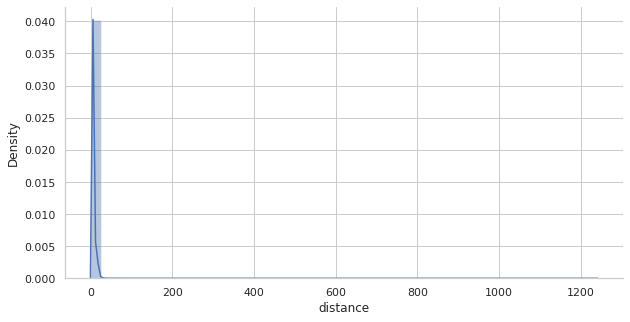

In [64]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.distplot(taxi_data['distance'])

So , it was right skewed distribution.

Lets check passenger number of all trips. 

In [65]:
taxi_data['passenger_count'].value_counts() # checking the value count

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

0 passenger trips numbers ares 60 , we will drop these values during outliers treatment. 

Visualize the distribution of trip duration 

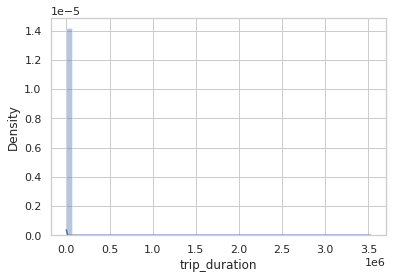

In [66]:
# Plotting distribution plot
sns.distplot(taxi_data['trip_duration'])

Too much outliers present in the data , thats why it is not visualising properly, lets, see the log distribution of this feature. 

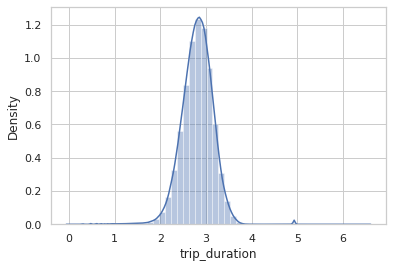

In [67]:
sns.distplot(np.log10(taxi_data['trip_duration']))

We need do to a proper outliers *treatment* for this . 

### **2. Bivariate analysis**

Visualizing Number of Trips count by days of week 

Text(0.5, 1.0, 'Number of trips in week days')

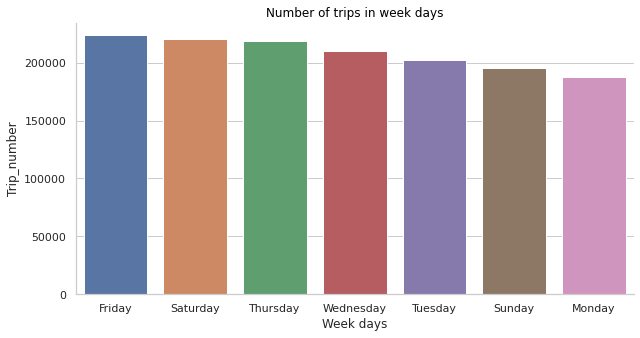

In [68]:
weekdays_number= taxi_data.pickup_day.value_counts().reset_index()
# Plotting graph
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.set_theme(style="whitegrid")
ax= sns.barplot(x='index',y='pickup_day',data=weekdays_number )
ax.set_ylabel("Trip_number")
ax.set_xlabel("Week days")
plt.title("Number of trips in week days")

Friday have the most number of trips , ofcourse it is natural beacuse , it is weekend

 Now will check Average duration of trips by days of the week

In [69]:
avg_duration_day= taxi_data.groupby(['pickup_day'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'}).sort_values(by = "avg_trip_duration" , ascending=False ,ignore_index=True)

In [70]:
avg_duration_day

,pickup_day,avg_trip_duration
0,Thursday,1006.528654
1,Friday,990.224200
2,Tuesday,983.463124
3,Wednesday,975.450494
4,Saturday,948.051175
5,Sunday,901.639395
6,Monday,897.947839


Thursday have the most trip duration , Lets visualize it by pie chart

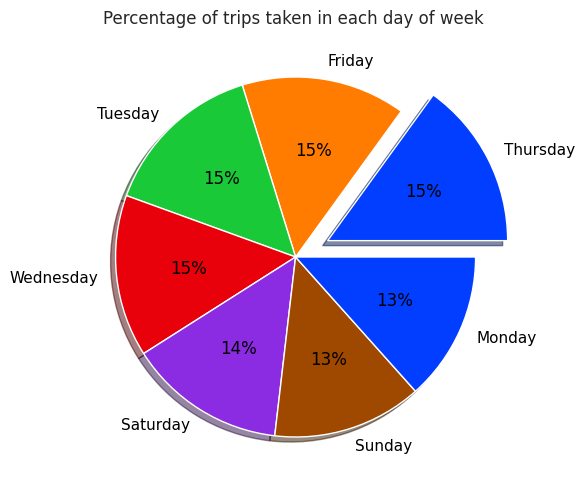

In [71]:
fig_1 = plt.figure(figsize=(8,5),dpi=100)
axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])
# plotting pie chart
explode = [0]*7
explode[0] = 0.2
colors = sns.color_palette('bright')[0:6]
z= avg_duration_day['pickup_day'].to_list()
plt.rcParams['text.color'] = 'black'
plt.pie(x=avg_duration_day['avg_trip_duration'],explode=explode,labels=z,labeldistance=1.1,colors=colors,shadow=True,textprops=dict(color="black"),autopct='%1.0f%%')
plt.title("Percentage of trips taken in each day of week ")
plt.show()

Now,  will use number of to replace these days. Change the categorical column to numerical. 

In [72]:
# one Hot encoding
encode_day= {'pickup_day':{'Monday':1,'Tuesday':2,'Wednesday':3,'Tuesday':4,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7},}
# replacing the date name with number
taxi_data=taxi_data.replace(encode_day)

Lets see, which hours of day have more pickup . 

Text(0.5, 1.0, 'Pickup Hours Distribution')

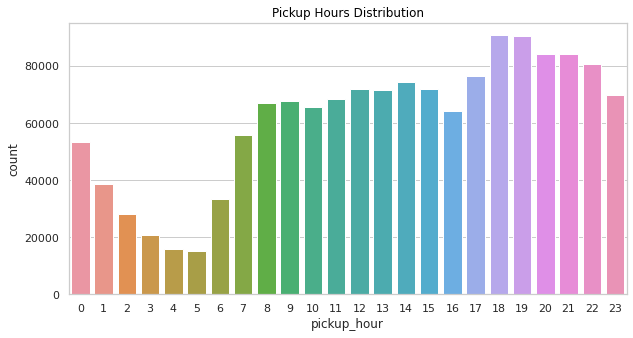

In [73]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x=taxi_data['pickup_hour'])
ax.set_title("Pickup Hours Distribution")

6 pm and 7pm of the evening time are the rush hour, people return the time to home from work, it makes sense. 

Lets, visualise , the store_and_fwd_flag with trip duration by violinplot. 

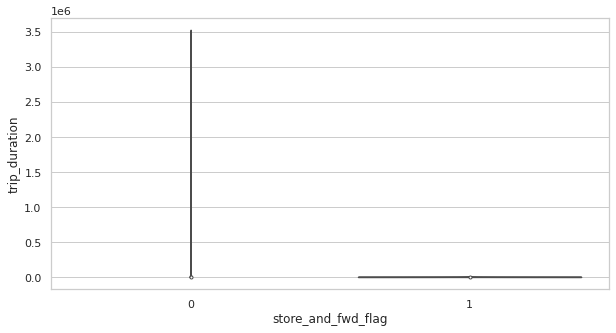

In [74]:
plt.figure(figsize=(10,5))
sns.violinplot(x= 'store_and_fwd_flag', y= 'trip_duration', data= taxi_data)

Violinplot is failed miserably here cause of outliers, we will plot once again after treating the outliers. 

Checking the relation between Average speed and trip duration. 

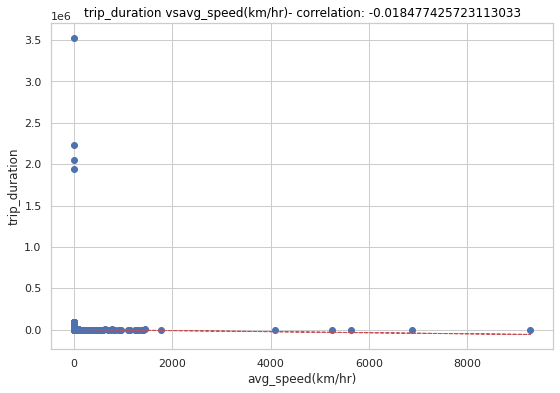

In [75]:
fig = plt.figure(figsize=(9, 6)) # Plotting the scatter plot. 
ax = fig.gca()
feature = taxi_data['avg_speed(km/hr)']
label = taxi_data['trip_duration']
correlation = feature.corr(label)
plt.scatter(x=feature, y=label)
plt.xlabel('avg_speed(km/hr)')
plt.ylabel('trip_duration')
ax.set_title('trip_duration vs' +'avg_speed(km/hr)' + '- correlation: ' + str(correlation))
z = np.polyfit(taxi_data['avg_speed(km/hr)'], taxi_data['trip_duration'], 1)
y_hat = np.poly1d(z)(taxi_data['avg_speed(km/hr)'])
plt.plot(taxi_data['avg_speed(km/hr)'], y_hat, "r--", lw=1)

plt.show()

And once again so many outliers disrupt the  actual visualization. 

# **Handling Outliers**

In a day , there are 86400 seconds, so more than 86400 seconds trip duration is not possible. 

In [76]:
# Checking the trip duration which is more than 1 day.
taxi_data[taxi_data['trip_duration']>86400] 

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,0,1939736,20.160235,2016,1,5,0,19,42,4,0.04
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,0,2049578,5.992874,2016,2,13,22,38,0,6,0.01
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,0,2227612,1.633027,2016,1,5,6,14,15,4,0.00
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,0,3526282,19.926608,2016,2,13,22,46,52,6,0.02


We can see some of these duration are several days , We will exclude this rows , also distance is not much, it may be trips for few days. 

Lets, plot the boxplot of the trip duration , for detecting the outliers. 

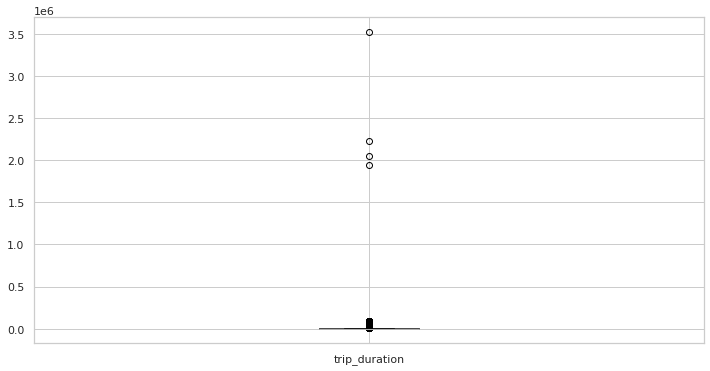

In [77]:
# plotting box plot
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='trip_duration')

Lets, drop these extreme outliers but we can not drop all values, which are outliers beacuse this type of data may be exist in testing data, thus model  will be impacted. 

In [78]:
# Finding 0.998 quantile 
upper_lim = taxi_data['trip_duration'].quantile(.998)
upper_lim

5551.71399999992

In [79]:
## Droping the value which is greater than quantile 0.998
taxi_data=taxi_data[taxi_data['trip_duration']<upper_lim]

In [80]:
taxi_data.shape

(1455726, 20)

Inspecting outliers of average speed through boxplot.

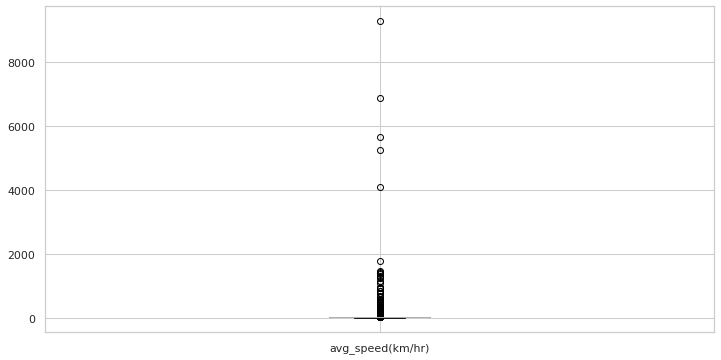

In [81]:
## Plotting boxplot 
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='avg_speed(km/hr)')

Average Speed greater than 180 km is not possible , so lets see which rows have average speed more than 180 km 

In [82]:
taxi_data[taxi_data['avg_speed(km/hr)']>180]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,0,2,0.703342,2016,6,23,13,36,48,4,1266.01
107171,id1656254,2,2016-01-18 00:35:38,2016-01-18 00:35:54,1,-73.805527,40.651360,-73.804230,40.661629,0,16,1.145626,2016,1,18,0,35,38,1,257.77
133641,id2362780,2,2016-06-30 05:01:03,2016-06-30 05:01:11,1,-74.164268,40.711639,-74.179352,40.711342,0,8,1.274983,2016,6,30,5,1,3,4,573.74
171801,id1733307,2,2016-06-26 18:02:38,2016-06-26 18:02:50,1,-73.792725,40.656902,-73.788948,40.647270,0,12,1.116290,2016,6,26,18,2,38,7,334.89
176589,id1724402,1,2016-05-17 06:34:59,2016-05-17 06:36:27,1,-73.969231,40.798122,-73.999260,40.753773,0,88,5.539157,2016,5,17,6,34,59,4,226.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328401,id1644758,2,2016-01-03 14:41:12,2016-01-03 14:44:19,1,-73.999992,40.689610,-73.965492,40.806030,0,187,13.252680,2016,1,3,14,41,12,7,255.13
1359910,id3628988,1,2016-05-05 18:21:37,2016-05-05 18:30:45,1,-79.569733,41.586273,-80.355431,42.090183,0,548,85.972969,2016,5,5,18,21,37,4,564.79
1390507,id3141426,2,2016-05-06 18:29:00,2016-05-06 18:29:05,1,-73.874718,40.730610,-73.867432,40.732868,0,5,0.664623,2016,5,6,18,29,0,5,478.53
1398157,id2905190,2,2016-03-05 00:17:29,2016-03-05 00:17:32,1,-74.003487,40.732609,-74.004189,40.731274,0,3,0.159683,2016,3,5,0,17,29,6,191.62


some average speed was too much , like 250 km/hour, which was practically impossible. 

We will drop those rows, of which average speed is more than 100 km/ hour. 

In [83]:
taxi_data= taxi_data[taxi_data['avg_speed(km/hr)']<100]

we can see here that trip duration was so small , which was practically impossible, so we exclude rows of those, whose trip duration which was less than 30 seconds .

In [84]:
taxi_data=taxi_data[taxi_data['trip_duration']>30]

Lets check the number of rows, which trip duration value is 0 and Average speed is 0, and distance is 0.  

In [85]:
print('Duration of trip is 0, those number of rows are ',taxi_data[taxi_data['trip_duration'] == 0].shape[0])
print('averaeg speed of trip is 0, those number of rows are ',taxi_data[taxi_data['avg_speed(km/hr)'] == 0].shape[0])
print('Distance of trip is 0, those number of rows are ',taxi_data[(taxi_data.distance == 0)].shape[0])

Duration of trip is 0, those number of rows are  0
averaeg speed of trip is 0, those number of rows are  4561
Distance of trip is 0, those number of rows are  4544


we will first drop those rows, which passenger count is 0,
also trip distance is 0,

In [86]:
taxi_data= taxi_data[(taxi_data.passenger_count != 0)]
taxi_data= taxi_data[taxi_data['trip_duration'] != 0]
taxi_data= taxi_data[taxi_data['avg_speed(km/hr)'] != 0]

Lets check the trips duration once by box plot visualization, so that we have an idea that if there are any extreme outlier available. 

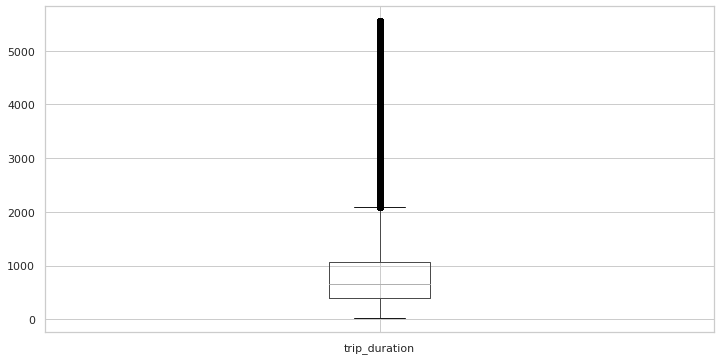

In [87]:
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='trip_duration')

In trip duration, there are some of the outliers. Lets see distribution of trip duration . 

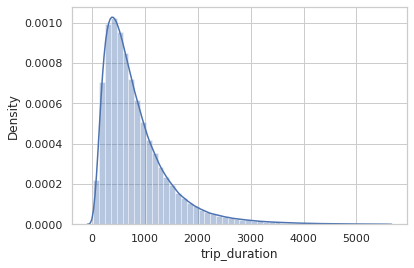

In [88]:
sns.distplot(taxi_data['trip_duration'])

So above plot is right skewed distribution, if we apply log in it , it will be left skewed. And lets confirm it . 

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

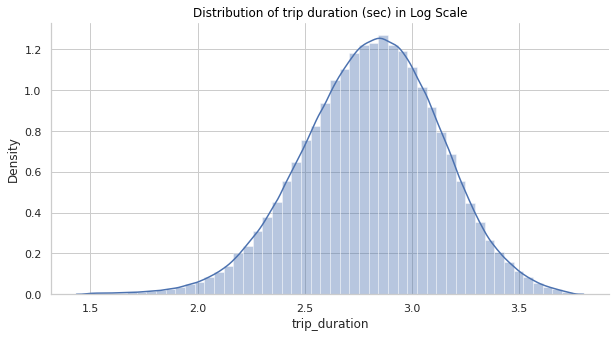

In [89]:
#log transformation
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.distplot(
    np.log10(taxi_data['trip_duration']))
plt.title("Distribution of trip duration (sec) in Log Scale")

Lets plot the violin plot again. 

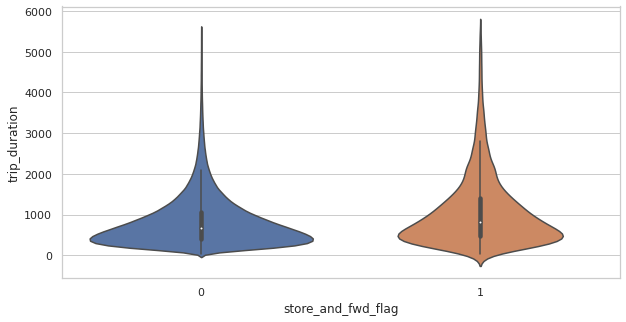

In [90]:
plt.figure(figsize=(10,5))
sns.violinplot(x= 'store_and_fwd_flag', y= 'trip_duration', data= taxi_data)

In above plot , we are observing that, the value 1 has median trip duration less than 1000 sec and same follows as 0 value. According to the graph,mostly distributed portion around median value . 

Now lets check the scatter plot of trip duration and average speed once again. 

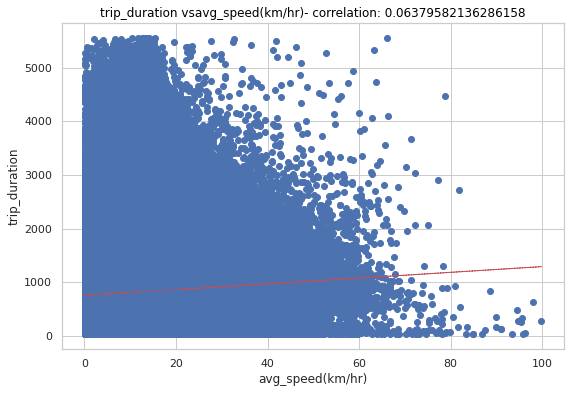

In [91]:
fig = plt.figure(figsize=(9, 6)) # Plotting the scatter plot. 
ax = fig.gca()
feature = taxi_data['avg_speed(km/hr)']
label = taxi_data['trip_duration']
correlation = feature.corr(label)
plt.scatter(x=feature, y=label)
plt.xlabel('avg_speed(km/hr)')
plt.ylabel('trip_duration')
ax.set_title('trip_duration vs' +'avg_speed(km/hr)' + '- correlation: ' + str(correlation))
z = np.polyfit(taxi_data['avg_speed(km/hr)'], taxi_data['trip_duration'], 1)
y_hat = np.poly1d(z)(taxi_data['avg_speed(km/hr)'])
plt.plot(taxi_data['avg_speed(km/hr)'], y_hat, "r--", lw=1)

plt.show()

From above graph, we can say that both are positivly correlated. 

In [92]:
# Describing the data once more. 
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_minute,pickup_second,pickup_day,avg_speed(km/hr)
count,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1446194.0,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06,1.446194e+06
mean,1.534209e+00,1.664561e+00,-7.397371e+01,4.075103e+01,-7.397359e+01,4.075190e+01,5.456391e-03,8.370838e+02,3.450237e+00,2016.0,3.516233e+00,1.550364e+01,1.360927e+01,2.959309e+01,2.947340e+01,4.327920e+00,1.446121e+01
std,4.988285e-01,1.313891e+00,6.785742e-02,2.816056e-02,6.671345e-02,3.244017e-02,7.366561e-02,6.441745e+02,3.928680e+00,0.0,1.680860e+00,8.703623e+00,6.399449e+00,1.732513e+01,1.731957e+01,1.776857e+00,7.679745e+00
min,1.000000e+00,1.000000e+00,-1.219333e+02,3.738930e+01,-1.219333e+02,3.738910e+01,0.000000e+00,3.100000e+01,4.236098e-04,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-02
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073744e+01,-7.399133e+01,4.073598e+01,0.000000e+00,3.990000e+02,1.245882e+00,2016.0,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,1.400000e+01,3.000000e+00,9.200000e+00
50%,2.000000e+00,1.000000e+00,-7.398177e+01,4.075416e+01,-7.397978e+01,4.075457e+01,0.000000e+00,6.640000e+02,2.106847e+00,2016.0,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,2.900000e+01,4.000000e+00,1.285000e+01
75%,2.000000e+00,2.000000e+00,-7.396748e+01,4.076837e+01,-7.396314e+01,4.076984e+01,0.000000e+00,1.074000e+03,3.889032e+00,2016.0,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,4.400000e+01,6.000000e+00,1.789000e+01
max,2.000000e+00,6.000000e+00,-7.309228e+01,4.169680e+01,-7.272073e+01,4.169335e+01,1.000000e+00,5.551000e+03,1.018582e+02,2016.0,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01,7.000000e+00,9.978000e+01


We will take three place value after the point of latitude and longitude column for ease of model building. 

In [93]:
taxi_data['pickup_longitude']= round(taxi_data['pickup_longitude'],3)
taxi_data['pickup_latitude']= round(taxi_data['pickup_latitude'],3)
taxi_data['dropoff_longitude']= round(taxi_data['dropoff_longitude'],3)
taxi_data['dropoff_latitude']= round(taxi_data['dropoff_latitude'],3)


Dropping the unnecessary columns , and create a new data set. 

In [94]:
col_to_drop= ['id','pickup_year','avg_speed(km/hr)','pickup_datetime','dropoff_datetime'] ## Dropping columns.
taxi_df= taxi_data.drop(col_to_drop, axis=1) # creating Data set . 

Applying dummies method of pandas, which is similar ot the one hot encoding method. 

In [95]:
taxi_df = pd.get_dummies(taxi_df, columns=["pickup_day", "pickup_hour"], prefix=["day", "hour"])

In [96]:
## Lets check the final shape of our data, before building the model. 
taxi_df.shape

(1446194, 43)

So, we didn't drop much rows , we drops rows as less as possible , so that it did not impact model while testing. 

In [97]:
## Checking info once again, if any value missing or not. 
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446194 entries, 0 to 1458643
Data columns (total 43 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1446194 non-null  int64  
 1   passenger_count     1446194 non-null  int64  
 2   pickup_longitude    1446194 non-null  float64
 3   pickup_latitude     1446194 non-null  float64
 4   dropoff_longitude   1446194 non-null  float64
 5   dropoff_latitude    1446194 non-null  float64
 6   store_and_fwd_flag  1446194 non-null  int64  
 7   trip_duration       1446194 non-null  int64  
 8   distance            1446194 non-null  float64
 9   pickup_month        1446194 non-null  int64  
 10  pickup_date         1446194 non-null  int64  
 11  pickup_minute       1446194 non-null  int64  
 12  pickup_second       1446194 non-null  int64  
 13  day_1               1446194 non-null  uint8  
 14  day_3               1446194 non-null  uint8  
 15  day_4          

Lets, check the correlation between variables, if there any Multicollinearity exist. 

In [99]:
taxi_df.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_month,pickup_date,pickup_minute,pickup_second,day_1,day_3,day_4,day_5,day_6,day_7,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
vendor_id,1.000000,0.287540,0.008554,0.002650,0.001835,0.005014,-0.079323,0.007174,0.009342,-0.006416,0.000731,-0.000354,0.001075,-0.000323,-0.001396,0.000262,-0.001476,0.000120,0.002844,0.001514,-0.001514,-0.005650,-0.007941,-0.006277,-0.007933,-0.006664,-0.001458,0.000430,0.002187,0.004266,0.004010,0.001155,-0.003110,-0.004005,-0.005158,-0.001096,0.002929,0.005028,0.002921,0.002605,0.003325,0.002723,0.000837
passenger_count,0.287540,1.000000,0.002454,-0.004843,-0.000106,-0.002426,-0.021690,0.014419,0.010716,-0.002462,0.001984,0.000979,0.000979,-0.008938,-0.009884,-0.013280,-0.000881,0.020766,0.015726,0.004101,0.005538,0.004326,0.003911,0.003410,-0.006549,-0.014780,-0.013434,-0.009528,-0.006887,-0.001601,0.000135,0.000353,0.001736,0.003235,0.001428,0.002210,0.000151,0.000009,0.000321,0.001721,0.004567,0.006369,0.005429
pickup_longitude,0.008554,0.002454,1.000000,0.041733,0.778975,0.129882,0.010711,0.203699,0.289816,0.004801,-0.001256,-0.002703,0.000560,0.017437,-0.001155,0.003696,-0.003486,-0.017843,0.001605,-0.006549,-0.014948,-0.019066,-0.017210,-0.007899,0.007282,0.009172,0.008248,0.001354,-0.001274,0.002408,0.001905,-0.000516,0.000393,0.006577,0.009315,0.012787,0.009643,-0.002930,-0.003825,-0.000528,-0.003293,-0.004435,-0.000789
pickup_latitude,0.002650,-0.004843,0.041733,1.000000,0.150793,0.431549,-0.009390,-0.234377,-0.313805,-0.002208,-0.007110,0.000693,0.000452,0.007024,0.015419,0.019934,0.004325,-0.026051,-0.026489,-0.052782,-0.052866,-0.047024,-0.039748,-0.021682,-0.008386,-0.000544,0.027236,0.031465,0.028605,0.031130,0.026785,0.026073,0.019288,0.016876,0.018390,0.014346,0.018169,0.014680,0.001431,-0.016714,-0.021976,-0.030817,-0.044690
dropoff_longitude,0.001835,-0.000106,0.778975,0.150793,1.000000,0.177806,0.007972,0.122838,0.198770,0.005256,-0.000925,-0.002977,0.000130,0.004790,-0.002478,-0.000140,0.000354,-0.008578,0.006692,0.008633,0.010045,0.008904,0.013423,0.027104,0.028651,0.015788,0.004567,-0.005999,-0.011736,-0.008384,-0.007539,-0.004947,-0.004390,0.001390,0.002882,0.003608,-0.001684,-0.009869,-0.011159,-0.007922,-0.004144,-0.001330,0.004772
dropoff_latitude,0.005014,-0.002426,0.129882,0.431549,0.177806,1.000000,-0.010601,-0.181824,-0.156673,-0.000828,-0.006049,0.001924,-0.000087,0.008377,0.010048,0.011508,0.000184,-0.019736,-0.013331,-0.032155,-0.027716,-0.026952,-0.022630,-0.019045,-0.014841,0.003046,0.018603,0.009737,0.004570,0.013435,0.012424,0.013799,0.010905,0.011865,0.017275,0.015868,0.017053,0.009345,0.000773,-0.006889,-0.009592,-0.016170,-0.026945
store_and_fwd_flag,-0.079323,-0.021690,0.010711,-0.009390,0.007972,-0.010601,1.000000,0.028255,0.029569,0.000443,0.001198,0.000114,0.001479,0.001981,0.000954,0.001697,0.001229,-0.002938,-0.003397,-0.002503,-0.001258,-0.001183,-0.000454,-0.001092,-0.001102,-0.001807,-0.003071,-0.001028,-0.000785,-0.001019,0.000598,0.001263,0.002667,0.003655,0.003134,0.004536,0.003218,0.000216,0.000107,-0.002190,-0.003652,-0.000564,-0.000606
trip_duration,0.007174,0.014419,0.203699,-0.234377,0.122838,-0.181824,0.028255,1.000000,0.771906,0.059206,0.011298,-0.010868,-0.000217,-0.016030,0.026490,0.039739,0.018767,-0.037517,-0.044813,-0.016296,-0.024633,-0.028912,-0.024553,-0.015943,-0.018983,-0.039164,-0.026298,-0.001187,0.002458,0.004113,0.013809,0.014949,0.021271,0.039027,0.044075,0.040474,0.033881,0.009967,-0.018119,-0.025610,-0.022617,-0.011540,-0.007753
distance,0.009342,0.010716,0.289816,-0.313805,0.198770,-0.156673,0.029569,0.771906,1.000000,0.016489,0.006726,-0.009019,0.000595,0.012402,-0.010822,-0.009154,-0.005235,-0.011511,0.028814,0.028524,0.021792,0.015532,0.02101

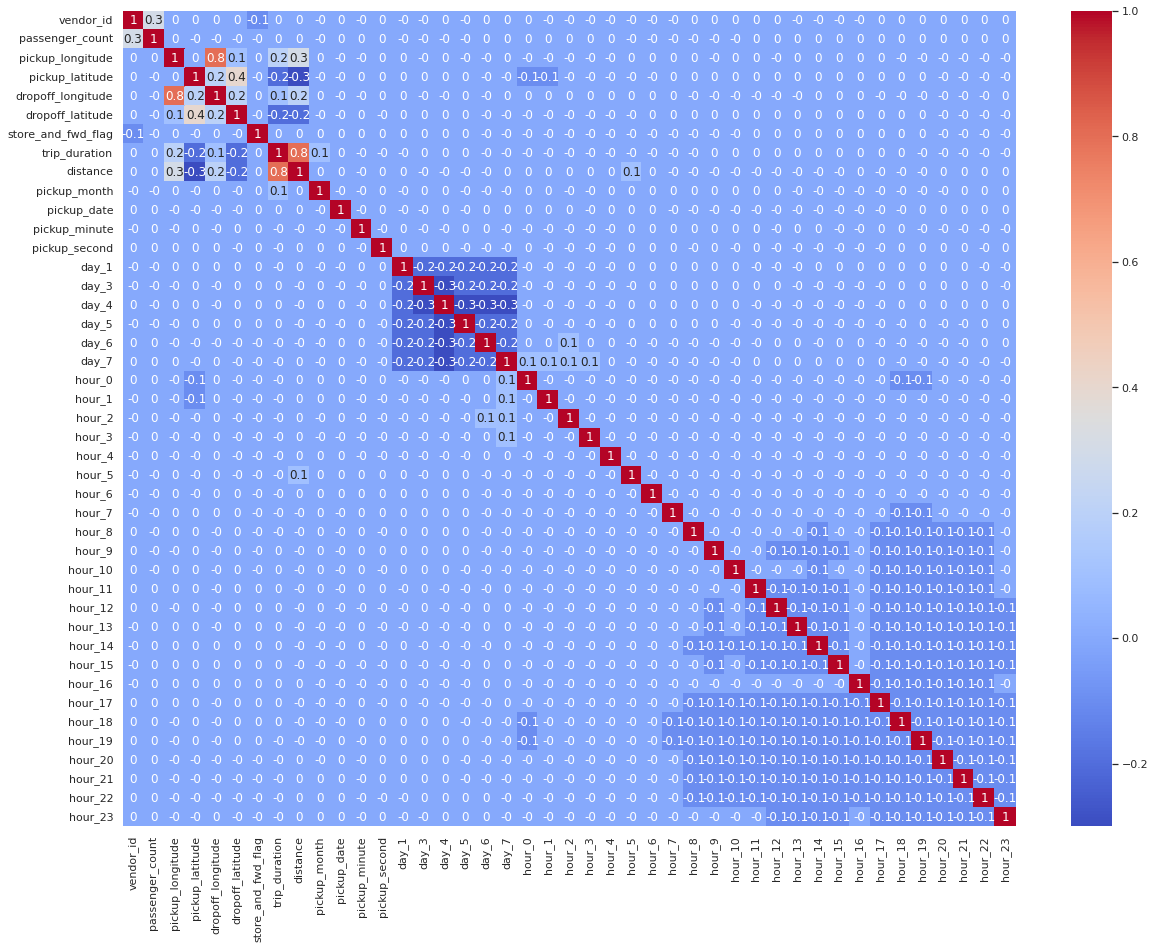

In [100]:
## Plotting the heatmap 
plt.figure(figsize=(20,15))
sns.heatmap(round(taxi_df.corr(),1),annot=True,cmap='coolwarm')

Now, we are ready to build the model with our data. 

# Model building 

Importing all the libraries necessary. 

In [101]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

## Importing metrics for evalution performance of the models.

from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

## Linear Regression model

Defining the Dependent value, and Independent features in our data set. 

In [103]:
## Independent features
X= taxi_df.drop(['trip_duration'],axis=1).apply(zscore) ## Applying z-square score so that different range of values can be standardized for model. 
## Dependent value or target variable
y= (taxi_df['trip_duration']) 

In [104]:
## spliting the train and test data set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 32)

In [105]:
## Fitting our training data
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [106]:
## Lets first predict the training data
train_pred= reg.predict(X_train)

In [107]:
## predicting the testing data
test_pred= reg.predict(X_test)

Using metrics of evalute the mean square error of the testing data and training data , R-square, Mean absolute error & adjusted R-square value. 

Lets look at the R-square and adjusted R-square values. 

In [191]:
print("The Mean squared error of test prediction is ",mean_squared_error(y_test, test_pred))
print("The Mean squared error of train prediction is ",mean_squared_error((y_train), (train_pred)))
print("The R-square score of test prediction is ",r2_score((y_test), (test_pred)))
print("The R-square score of train prediction is ",r2_score((y_train), (train_pred)))
print("The Adjusted R-square score of test prediction is ",1-((1- r2_score((y_test), (test_pred)))*(X_test.shape[0] - 1)/(X_test.shape[0] - X_test.shape[1] - 1)))
print("The Mean absolute error of test prediction is ",mean_absolute_error((y_test), (test_pred)))

The Mean squared error of test prediction is  149283.7603066344
The Mean squared error of train prediction is  148267.94491385797
The R-square score of test prediction is  0.6394693217607366
The R-square score of train prediction is  0.6428860512625683
The Adjusted R-square score of test prediction is  0.6394169618094023
The Mean absolute error of test prediction is  267.07409170441605


Lets visualize the actual test data and predicted test data , that model linear regression model predicted. 

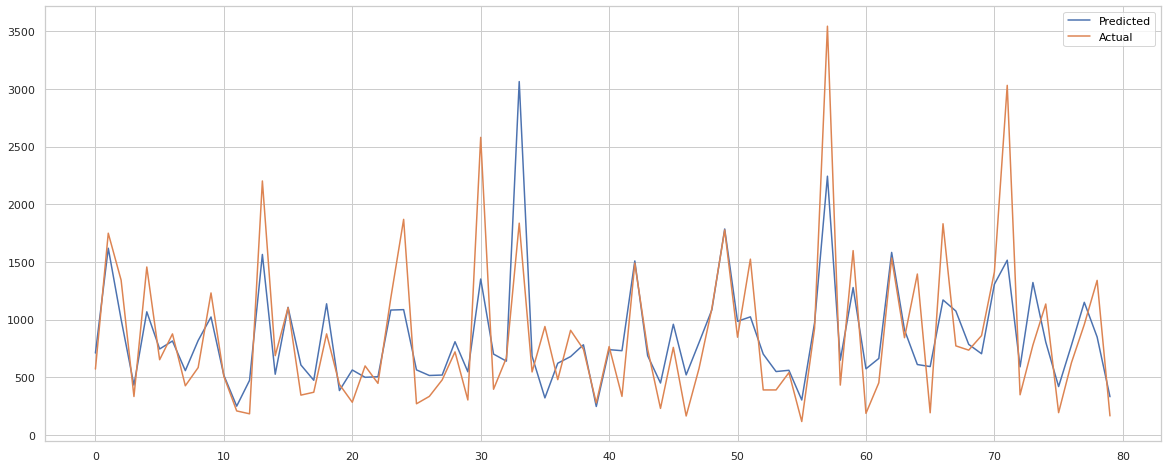

In [110]:
plt.figure(figsize=(20,8))
plt.plot((test_pred[20:100]))
plt.plot(np.array((y_test[20:100])))
plt.legend(["Predicted","Actual"])
plt.show()

Intercept or slope value and coefficient values are 

In [116]:
reg.intercept_

837.0676693884328

In [117]:
reg.coef_

array([-1.60977327e+00,  5.25965690e+00, -6.92077708e+00,  1.92444203e+01,
       -3.52009878e+00, -5.21723113e+01,  1.65156090e+00,  5.08684449e+02,
        3.07353039e+01,  5.14295167e+00, -2.52942486e+00, -4.04390476e-01,
        1.32341840e+14,  1.38874396e+14,  1.79204805e+14,  1.42416579e+14,
        1.41755241e+14,  1.34633978e+14, -5.29284200e+13, -4.52681553e+13,
       -3.87025930e+13, -3.34941550e+13, -2.91357054e+13, -2.84161005e+13,
       -4.21062877e+13, -5.40312002e+13, -5.91220386e+13, -5.94054610e+13,
       -5.84623788e+13, -5.97060614e+13, -6.10927924e+13, -6.09279356e+13,
       -6.20191943e+13, -6.10134853e+13, -5.78644214e+13, -6.29009349e+13,
       -6.81416716e+13, -6.80644562e+13, -6.58182642e+13, -6.58423181e+13,
       -6.44658586e+13, -6.02600695e+13])

### lasso Regression or L1 regression

In [ ]:
from sklearn.linear_model import Lasso
lasso  = Lasso(alpha=0.01 ) ## set learing rate as 0.01
## Fitting the train data
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso.score(X_train, y_train) ## evaluating model performance by model.score method. 

0.6428853882129684

In [ ]:
### Cross validation using Grid Search on lasso model
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-3,1e-2,1e-1,1,5]}
lasso_reg = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=3)
lasso_regressor= lasso_reg.fit(X_train, y_train)

Saving the model in pickle , so that later while using the model to predict test data, it won't take much time. 

In [ ]:
save_model_ = open("/content/drive/MyDrive/almabetter/lasso.pickle","wb")
pickle.dump(lasso_regressor, save_model_)
save_model_.close()

Opening the pickle file from drive while require. 

In [ ]:
model = open("/content/drive/MyDrive/almabetter/lasso.pickle", "rb")
ridge = pickle.load(model)
model.close()

Lets see the best parameters. 

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.1}

Using  {'alpha': 0.1}  the negative mean squared error is:  -148373.66769061316


In [ ]:
## Predciting the test values. 
y_pred_lasso = lasso_regressor.predict(X_test)

Plotting the predicted and actual value. So that we can visualise properly. 

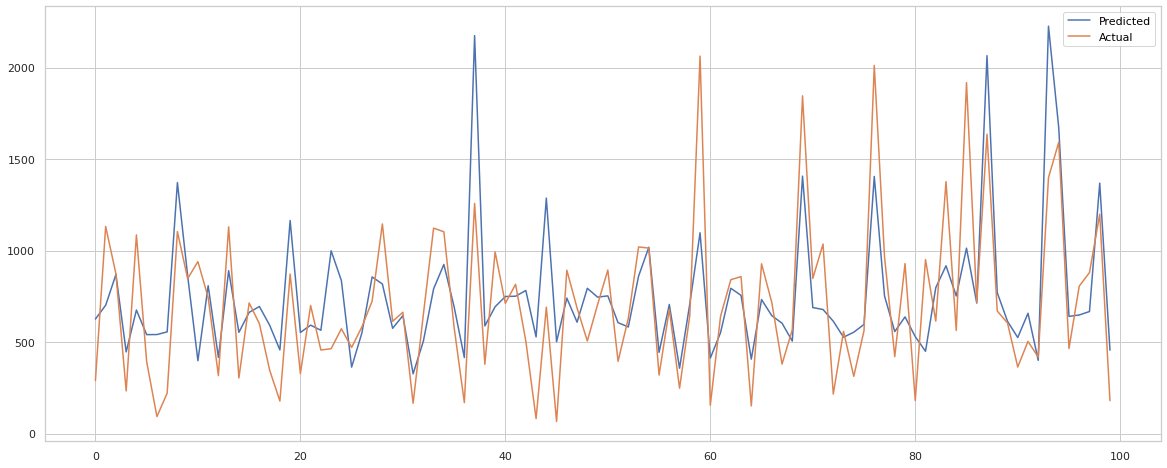

In [ ]:
plt.figure(figsize=(20,8))
plt.plot((y_pred_lasso)[:100])
plt.plot((np.array(y_test)[:100]))
plt.legend(["Predicted","Actual"])
plt.show()

Evaluating the model by metrics, i.e MSE, RMSE, R2_score nad Adjusted R2

In [ ]:
MSE  = mean_squared_error((y_test), (y_pred_lasso))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_lasso))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_lasso)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 149281.8781333346
RMSE : 386.3701310056648
R2 : 0.6394738673403424
Adjusted R2 :  0.6394215080491638


### Ridge Regression or L2 regression

In [193]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters_2 = {'alpha': [1e-4,1e-3,1e-2,1,5]}
ridge_reg = GridSearchCV(ridge, parameters_2, scoring='neg_mean_squared_error', cv=5)
ridge_regressor= ridge_reg.fit(X_train,y_train)

In [194]:
# Saving the model as pickle
save_model_1 = open("/content/drive/MyDrive/almabetter/ridge.pickle","wb")
pickle.dump(ridge_regressor, save_model_1)
save_model_1.close()

In [197]:
model1 = open("/content/drive/MyDrive/almabetter/ridge.pickle", "rb")
ridge_regressor = pickle.load(model1)
model1.close()

In [198]:
## looking for best parameters. 
print("The best fit alpha value is found out to be :" , ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 5}

Using  {'alpha': 5}  the negative mean squared error is:  -159740.76367567695


In [199]:
# Predicting the testing values. 
y_pred_ridge = ridge_regressor.predict(X_test)

Evaluating the model by metrics. 

In [200]:
MSE  = mean_squared_error((y_test), (y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 149281.27085506255
RMSE : 386.36934512854737
R2 : 0.6394753339596642
Adjusted R2 :  0.639422974881483


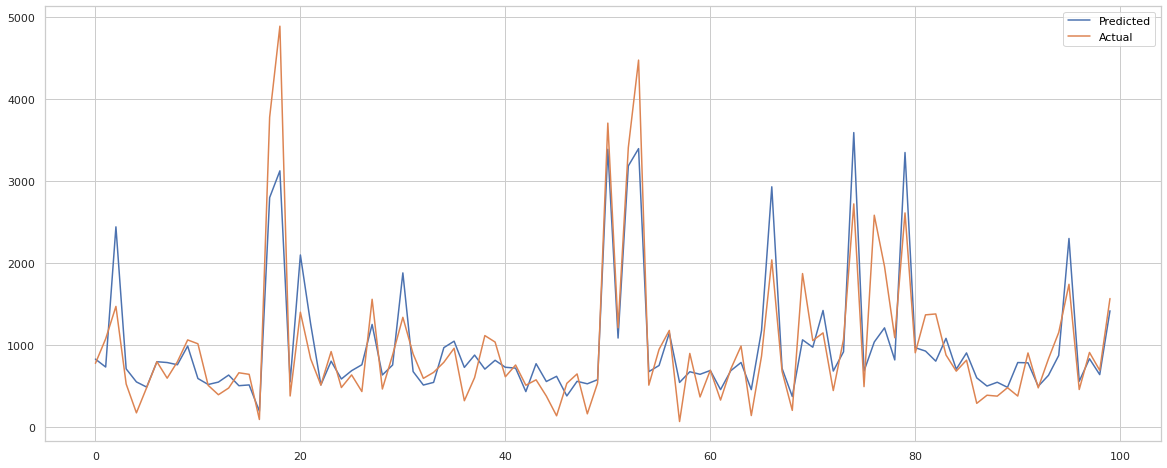

In [203]:
## Plotting the graphs between actual and predicted values. 
plt.figure(figsize=(20,8))
plt.plot((y_pred_ridge )[100:200])
plt.plot((np.array(y_test))[100:200])
plt.legend(["Predicted","Actual"])
plt.show()

### Elastic Net Regression

In [204]:
from sklearn.linear_model import ElasticNet
#a * L1 + b * L2
#alpha = a + b and l1_ratio = a / (a + b)
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.4)
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.4,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [205]:
elasticnet.score(X_test, y_test) ## Checking model performance by model.score method. 

0.639418582438818

In [206]:
y_pred_en = elasticnet.predict(X_test) ## predicting the testing values. 

In [219]:
from sklearn.model_selection import GridSearchCV
elastic = ElasticNet()
parameters_3 = {'alpha': [1e-3,1e-2,1e-1,1],'l1_ratio':[0.2,0.3,0.4],'max_iter':[100]}
elastic_reg = GridSearchCV(elastic, parameters_3, scoring='neg_mean_squared_error',cv=5)
elastic_regressor= elastic_reg.fit(X_train, y_train)

In [223]:
save_model_2 = open("/content/drive/MyDrive/almabetter/elastic.pickle","wb") ## Saving the model 
pickle.dump(elastic_regressor, save_model_2)
save_model_2.close()

In [224]:
model_2 = open("/content/drive/MyDrive/almabetter/elastic.pickle", "rb") ##Opening the model
elastic_regressor= pickle.load(model_2)
model_2.close()

In [225]:
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.1, 'l1_ratio': 0.2, 'max_iter': 100}

Using  {'alpha': 0.1, 'l1_ratio': 0.2, 'max_iter': 100}  the negative mean squared error is:  -150763.14231896438


In [226]:
y_pred_elastic = elastic_regressor.predict(X_test)

Evaluating the model by different metrics. 

In [227]:
MSE  = mean_squared_error((y_test), (y_pred_elastic))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_elastic))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_elastic)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 151143.95643408404
RMSE : 388.7723709757215
R2 : 0.6349768185567046
Adjusted R2 :  0.6349238061581216


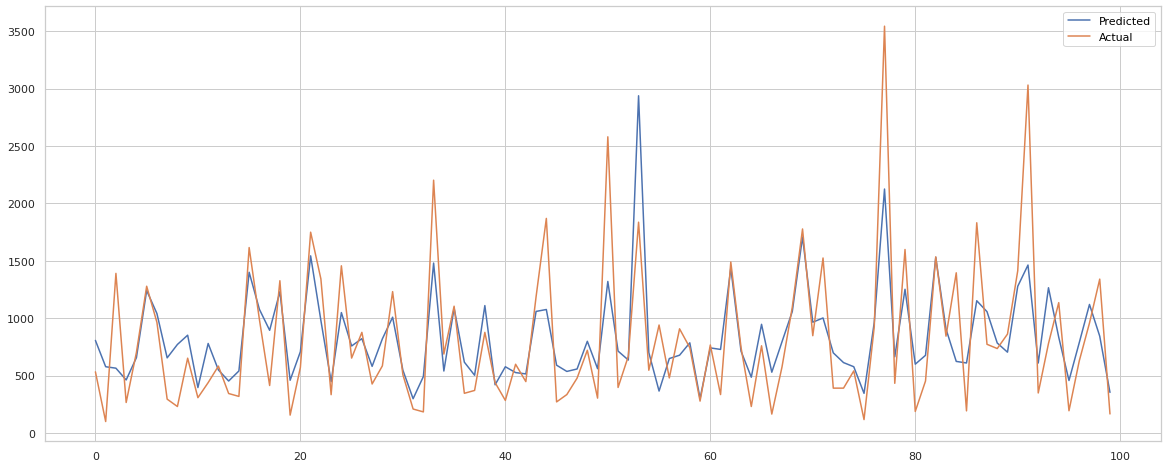

In [215]:
## Plotting the gapdh between actual value and predicted values. 
plt.figure(figsize=(20,8))
plt.plot((y_pred_elastic)[:100])
plt.plot((np.array(y_test))[:100])
plt.legend(["Predicted","Actual"])
plt.show()

## Xgboost Regressor model

XGboost use boosting algorithms for predict.  

In [155]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
xgb= XGBRegressor()
grid_values= {'n_estimators':[100], 'max_depth':[6,7], 'eta':[0.01], 'colsample_bytree':[0.8]}
Regressor = GridSearchCV(xgb, param_grid = grid_values, scoring = 'neg_mean_squared_error', cv=3)
xgb_reg= Regressor.fit(X_train, y_train) ## Fitting the training data 

[06:34:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:37:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:40:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:42:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:46:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:49:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:52:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [207]:
save_model_3 = open("/content/drive/MyDrive/almabetter/xgbregressor.pickle","wb") ## Saving the model
pickle.dump(xgb_reg, save_model_3)
save_model_3.close()

In [209]:
model_3 = open("/content/drive/MyDrive/almabetter/xgbregressor.pickle", "rb")
xgb_reg= pickle.load(model_3)
model_3.close()

[07:54:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [210]:
y_pred_xgb= xgb_reg.predict(X_test)
r2_score((y_test),(y_pred_xgb),multioutput='variance_weighted')


0.7742601916781274

Evaluating the model 

In [159]:
MSE  = mean_squared_error((y_test), (y_pred_xgb))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_xgb))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_xgb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 93471.34507877781
RMSE : 305.7308376313679
R2 : 0.7742601916781274
Adjusted R2 :  0.7742274074350898


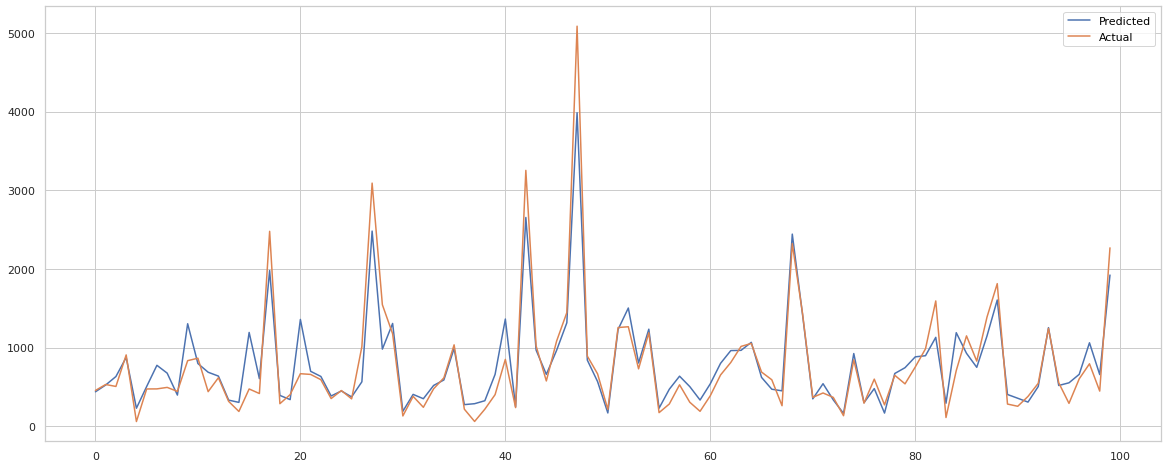

In [ ]:
## Plotting the graph between actual and predicted values. 
plt.figure(figsize=(20,8))
plt.plot((y_pred_xgb)[400:500])
plt.plot((np.array(y_test))[400:500])
plt.legend(["Predicted","Actual"])
plt.show()

In [160]:
print("The best fit values is found out to be :" ,Regressor.best_params_)


The best fit values is found out to be : {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'n_estimators': 100}


In [161]:
mean_squared_error((y_test), (y_pred_xgb))

93471.34507877781

Plotting Tree diagram for better understanding. 

[07:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


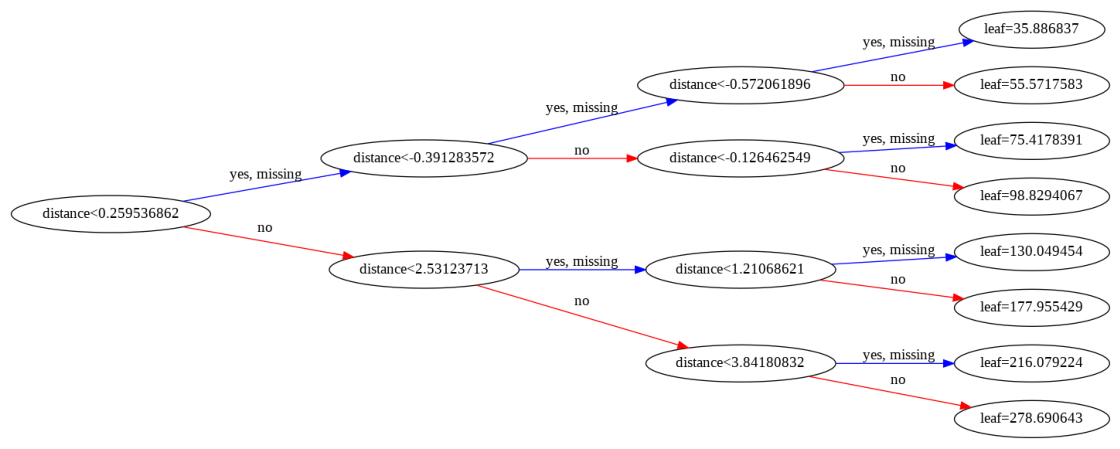

In [167]:
from xgboost import plot_tree
xgb.fit(X_train, y_train)
_, ax = plt.subplots(figsize=(20,8)) # Resize figure
plot_tree(xgb,rankdir='LR',ax=ax)
plt.show()

## Hist Gradient Boosting Regressor model

Though it is on experimental phase, still we try this model to find out model prediction.

In [168]:
from sklearn.experimental    import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

histogram_gradient_boosting = HistGradientBoostingRegressor()
histogram_gradient_boosting.fit(X_train,y_train)

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

In [169]:
y_pred_gbr= histogram_gradient_boosting.predict(X_test)

In [170]:
histogram_gradient_boosting.score(X_test,y_test)

0.7782283293876835

In [171]:
r2_score(y_test,y_pred_gbr)

0.7782283293876835

In [172]:
mean_squared_error((y_test), (y_pred_gbr))

91828.27125884633

In [176]:
MSE  = mean_squared_error((y_test), (y_pred_gbr))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_gbr))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_gbr)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))
print("MAE (Mean absolute error) :", mean_absolute_error((y_test), (y_pred_gbr)))

MSE : 91828.27125884633
RMSE : 303.031799088555
R2 : 0.7782283293876835
Adjusted R2 :  0.7781961214381762
MAE (Mean absolute error) : 200.58469681549863


## Random Forest Regressor model

It is a model, that use Bagging( Bootstrap Aggregating) method for predict. 

In [139]:
from sklearn.ensemble import RandomForestRegressor

In [140]:
RF= RandomForestRegressor(n_estimators=20, random_state=42)
RF_reg= RF.fit(X_train,y_train)

In [141]:
save_model_4 = open("/content/drive/MyDrive/almabetter/rf_reg.pickle","wb")
pickle.dump(RF_reg, save_model_4)
save_model_4.close()

In [146]:
model_4 = open("/content/drive/MyDrive/almabetter/rf_reg.pickle", "rb")
RF_reg= pickle.load(model_4)
model_4.close()

In [177]:
y_pred_rf= RF_reg.predict(X_test)

In [180]:
MSE  = mean_squared_error((y_test), (y_pred_rf))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_rf))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_rf)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))
print("MAE (Mean absolute error) :", mean_absolute_error((y_test), (y_pred_rf)))

MSE : 87396.28374385023
RMSE : 295.6286247031066
R2 : 0.7889318879090351
Adjusted R2 :  0.7889012344397346
MAE (Mean absolute error) : 194.21904117356237


We used Random forest, Xgboost, Hist gradient boositng, but still we did not get 80% accuracy , lets try lightGBM model, all model wroks differently, on each data set, we have to try different model to find which model is best suited for us . 

## LightGBM model 

In [125]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV


In [126]:
lgb_reg= LGBMRegressor()
grid_values_= {'n_estimators':[1000],  'learning_rate ':[0.01,0.001,0.0001,1]}
lgb_Regressor = GridSearchCV(lgb_reg, param_grid = grid_values_, scoring = 'neg_mean_squared_error', cv=3)
lgb_ = lgb_Regressor.fit(X_train, y_train)


In [127]:
lgb_.best_params_

{'learning_rate ': 0.01, 'n_estimators': 1000}

In [135]:
save_model_5 = open("/content/drive/MyDrive/almabetter/lgb.pickle","wb")
pickle.dump(lgb_, save_model_5)
save_model_5.close()

In [136]:
model_5 = open("/content/drive/MyDrive/almabetter/lgb.pickle", "rb")
lgb_= pickle.load(model_5)
model_5.close()

In [137]:
y_pred_lgb= lgb_.predict(X_test)

In [181]:
MSE  = mean_squared_error((y_test), (y_pred_lgb))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test), (y_pred_lgb))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_lgb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))
print("MAE (Mean absolute error) :", mean_absolute_error((y_test), (y_pred_lgb)))

MSE : 74434.02272948917
RMSE : 272.82599350041625
R2 : 0.8202366510354652
Adjusted R2 :  0.820210543963941
MAE (Mean absolute error) : 177.51441271171456


Plotting the graph between actual testing value and predicted testing value. 

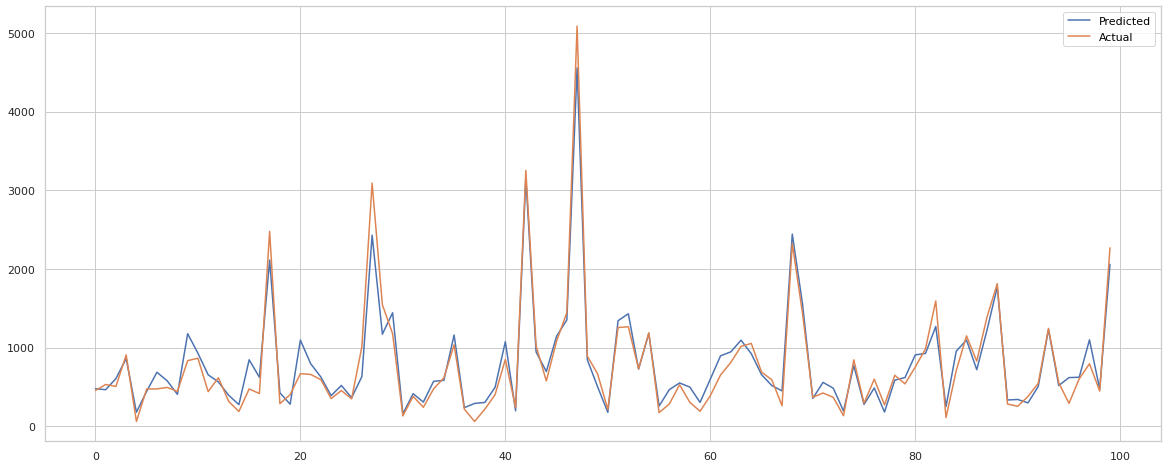

In [ ]:
plt.figure(figsize=(20,8))
plt.plot((y_pred_lgb)[400:500])
plt.plot((np.array(y_test))[400:500])
plt.legend(["Predicted","Actual"])
plt.show()

## Adaboost regressor model

In [182]:
from sklearn.ensemble import AdaBoostRegressor

In [183]:
ada = AdaBoostRegressor(learning_rate=0.001) ## Setting learning rate as 0.001

In [184]:
ada.fit(X_train,y_train) ## Fitting the model

AdaBoostRegressor(base_estimator=None, learning_rate=0.001, loss='linear',
                  n_estimators=50, random_state=None)

In [188]:
y_pred_ada= ada.predict(X_test) ## predicting the test data . 

In [189]:
print("R2 Score is ",r2_score(y_test,y_pred_ada)) ## R2 score of model
print("The MSE value is ",mean_squared_error((y_test), (y_pred_ada))) ## MSE value 

R2 Score is  0.62218351214068
The MSE value is  156441.23903390678


## Stacking method

In [118]:
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.experimental    import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

In stacking method we choose three models for the first layer, and for final layer we choose **lightgbm** model as it gave us mosr R-square score. 

In [119]:
estimators = [('ridge', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 2, 5])),
              ('RF', RandomForestRegressor(n_estimators=10)),
               ('Hgb', HistGradientBoostingRegressor())]
final_estimator = LGBMRegressor(learning_rate= 0.01)
stack = StackingRegressor(estimators=estimators,final_estimator=final_estimator)
stack_reg= stack.fit(X_train, y_train)

In [124]:
save_model_stack = open("/content/drive/MyDrive/almabetter/stack.pickle","wb") ##Saving the model 
pickle.dump(stack_reg, save_model_stack)
save_model_stack.close()

In [ ]:
model_stack = open("/content/drive/MyDrive/almabetter/stack.pickle", "rb") ## Opening the model
lgb_= pickle.load(model_stack)
model_stack.close()

In [121]:
y_pred_stack = stack_reg.predict(X_test) ## Predicting the test data

In [122]:
print("R2 Score is ", r2_score(y_test, y_pred_stack))
print("The MSE value is ",mean_squared_error((y_test), (y_pred_stack)))

0.68573501362858

# Conclusion